# Stochastic Solver: Mixing stochastic and deterministic equations

Copyright (C) 2011 and later, Paul D. Nation & Robert J. Johansson

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from qutip import (
    about,
    coherent,
    destroy,
    fock,
    liouvillian,
    mcsolve,
    mesolve,
    plot_expectation_values,
    smesolve,
)

%matplotlib inline

rcParams["font.family"] = "STIXGeneral"
rcParams["mathtext.fontset"] = "stix"
rcParams["font.size"] = "14"

## Direct photo-detection

Here we follow an example from Wiseman and Milburn, *Quantum measurement and control*, section. 4.8.1.

Consider cavity that leaks photons with a rate $\kappa$. The dissipated photons are detected with an inefficient photon detector,
with photon-detection efficiency $\eta$. The master equation describing this scenario, where a separate dissipation channel has been added for detections and missed detections, is

$\dot\rho = -i[H, \rho] + \mathcal{D}[\sqrt{1-\eta} \sqrt{\kappa} a] + \mathcal{D}[\sqrt{\eta} \sqrt{\kappa}a]$

To describe the photon measurement stochastically, we can unravelling only the dissipation term that corresponds to detections, and leaving the missed detections as a deterministic dissipation term, we obtain [Eq. (4.235) in W&M]

$d\rho = \mathcal{H}[-iH -\eta\frac{1}{2}a^\dagger a] \rho dt + \mathcal{D}[\sqrt{1-\eta} a] \rho dt + \mathcal{G}[\sqrt{\eta}a] \rho dN(t)$

or

$d\rho = -i[H, \rho] dt + \mathcal{D}[\sqrt{1-\eta} a] \rho dt -\mathcal{H}[\eta\frac{1}{2}a^\dagger a] \rho dt + \mathcal{G}[\sqrt{\eta}a] \rho dN(t)$

where

$\displaystyle \mathcal{G}[A] \rho = \frac{A\rho A^\dagger}{\mathrm{Tr}[A\rho A^\dagger]} - \rho$

$\displaystyle \mathcal{H}[A] \rho = A\rho + \rho A^\dagger - \mathrm{Tr}[A\rho + \rho A^\dagger] \rho $

and $dN(t)$ is a Poisson distributed increment with $E[dN(t)] = \eta \langle a^\dagger a\rangle (t)$.

### Formulation in QuTiP

The photocurrent stochastic master equation is written in the form:

$\displaystyle d\rho(t) = -i[H, \rho] dt + \mathcal{D}[B] \rho dt 
- \frac{1}{2}\mathcal{H}[A^\dagger A] \rho(t) dt 
+ \mathcal{G}[A]\rho(t) d\xi$

where the first two term gives the deterministic master equation (Lindblad form with collapse operator $B$ (c_ops)) and $A$ the stochastic collapse operator (sc_ops). 

Here $A = \sqrt{\eta\gamma} a$ and $B = \sqrt{(1-\eta)\gamma} $a.

In QuTiP, the monte carlo solver can solve this equation when the deterministic part is passed as a liouvillian.

In [2]:
N = 15
w0 = 0.5 * 2 * np.pi
times = np.linspace(0, 15, 150)
dt = times[1] - times[0]
gamma = 0.1

a = destroy(N)

H = w0 * a.dag() * a

rho0 = fock(N, 5)

e_ops = [a.dag() * a, a + a.dag()]

### Highly efficient detection

In [3]:
eta = 0.7
c_ops = [np.sqrt(1 - eta) * np.sqrt(gamma) * a]  # collapse operator B
sc_ops = [np.sqrt(eta) * np.sqrt(gamma) * a]  # stochastic collapse operator A

In [4]:
result_ref = mesolve(H, rho0, times, c_ops + sc_ops, e_ops)

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


In [5]:
result1 = mcsolve(
    liouvillian(H, c_ops),
    rho0,
    times,
    sc_ops,
    e_ops=e_ops,
    ntraj=1,
)

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00


Total run time:   0.00s


In [6]:
result2 = mcsolve(
    liouvillian(H, c_ops),
    rho0,
    times,
    sc_ops,
    e_ops=e_ops,
    ntraj=10,
)

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00


20.0%. Run time:   0.00s. Est. time left: 00:00:00:00


30.0%. Run time:   0.01s. Est. time left: 00:00:00:00


40.0%. Run time:   0.01s. Est. time left: 00:00:00:00


50.0%. Run time:   0.01s. Est. time left: 00:00:00:00


60.0%. Run time:   0.02s. Est. time left: 00:00:00:00


70.0%. Run time:   0.02s. Est. time left: 00:00:00:00


80.0%. Run time:   0.02s. Est. time left: 00:00:00:00


90.0%. Run time:   0.03s. Est. time left: 00:00:00:00


100.0%. Run time:   0.03s. Est. time left: 00:00:00:00


Total run time:   0.04s


In [7]:
np.array(result2.runs_photocurrent).dtype

dtype('float64')

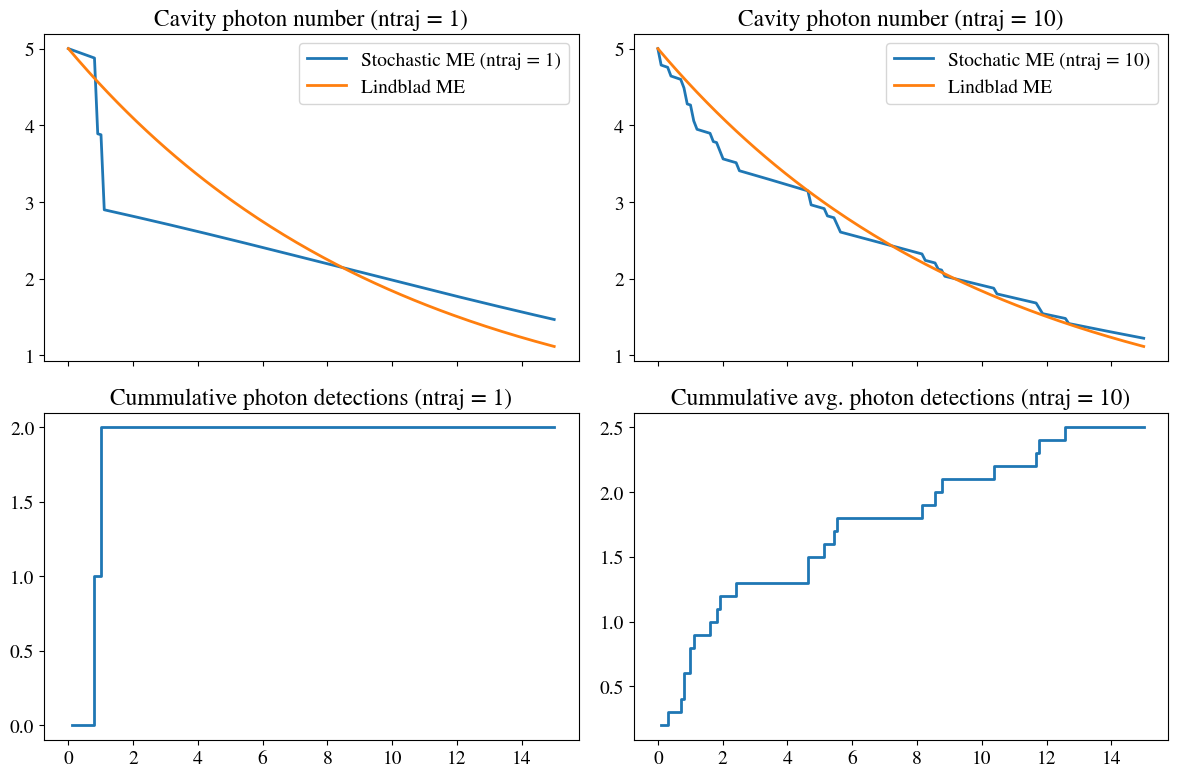

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

axes[0, 0].plot(
    times, result1.expect[0], label=r"Stochastic ME (ntraj = 1)", lw=2
)
axes[0, 0].plot(times, result_ref.expect[0], label=r"Lindblad ME", lw=2)
axes[0, 0].set_title("Cavity photon number (ntraj = 1)")
axes[0, 0].legend()

axes[0, 1].plot(
    times, result2.expect[0], label=r"Stochatic ME (ntraj = 10)", lw=2
)
axes[0, 1].plot(times, result_ref.expect[0], label=r"Lindblad ME", lw=2)
axes[0, 1].set_title("Cavity photon number (ntraj = 10)")
axes[0, 1].legend()

axes[1, 0].step(times[1:], dt * np.cumsum(result1.photocurrent), lw=2)
axes[1, 0].set_title("Cummulative photon detections (ntraj = 1)")
axes[1, 1].step(times[1:], dt * np.cumsum(result2.photocurrent), lw=2)
axes[1, 1].set_title("Cummulative avg. photon detections (ntraj = 10)")

fig.tight_layout()

### Highly inefficient photon detection

In [9]:
eta = 0.1
c_ops = [np.sqrt(1 - eta) * np.sqrt(gamma) * a]  # collapse operator B
sc_ops = [np.sqrt(eta) * np.sqrt(gamma) * a]  # stochastic collapse operator A

In [10]:
result_ref = mesolve(H, rho0, times, c_ops + sc_ops, e_ops)

In [11]:
result1 = mcsolve(
    liouvillian(H, c_ops),
    rho0,
    times,
    sc_ops,
    e_ops=e_ops,
    ntraj=1,
)

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00


Total run time:   0.00s


In [12]:
result2 = mcsolve(
    liouvillian(H, c_ops),
    rho0,
    times,
    sc_ops,
    e_ops=e_ops,
    ntraj=10,
)

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00


20.0%. Run time:   0.00s. Est. time left: 00:00:00:00


30.0%. Run time:   0.01s. Est. time left: 00:00:00:00


40.0%. Run time:   0.01s. Est. time left: 00:00:00:00


50.0%. Run time:   0.01s. Est. time left: 00:00:00:00


60.0%. Run time:   0.02s. Est. time left: 00:00:00:00


70.0%. Run time:   0.02s. Est. time left: 00:00:00:00


80.0%. Run time:   0.02s. Est. time left: 00:00:00:00


90.0%. Run time:   0.03s. Est. time left: 00:00:00:00


100.0%. Run time:   0.03s. Est. time left: 00:00:00:00


Total run time:   0.03s


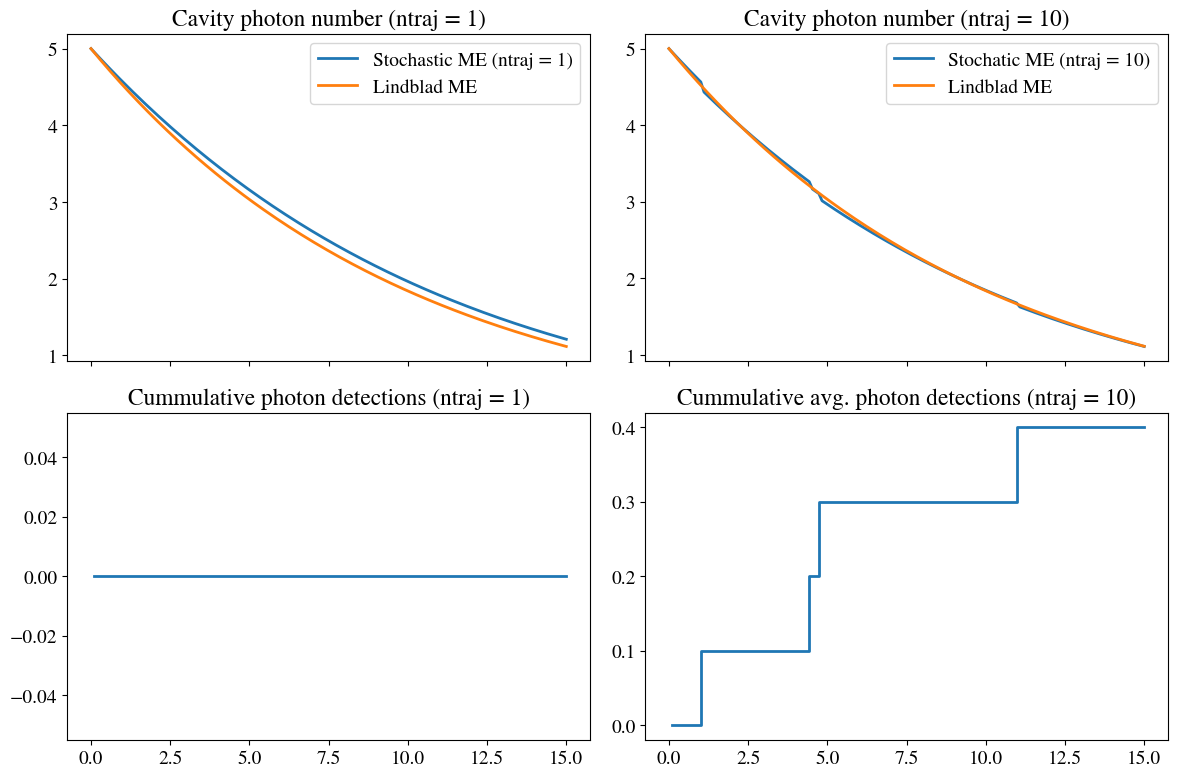

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

axes[0, 0].plot(
    times, result1.expect[0], label=r"Stochastic ME (ntraj = 1)", lw=2
)
axes[0, 0].plot(times, result_ref.expect[0], label=r"Lindblad ME", lw=2)
axes[0, 0].set_title("Cavity photon number (ntraj = 1)")
axes[0, 0].legend()

axes[0, 1].plot(
    times, result2.expect[0], label=r"Stochatic ME (ntraj = 10)", lw=2
)
axes[0, 1].plot(times, result_ref.expect[0], label=r"Lindblad ME", lw=2)
axes[0, 1].set_title("Cavity photon number (ntraj = 10)")
axes[0, 1].legend()

axes[1, 0].step(times[1:], dt * np.cumsum(result1.photocurrent[0]), lw=2)
axes[1, 0].set_title("Cummulative photon detections (ntraj = 1)")
axes[1, 1].step(times[1:], dt * np.cumsum(result2.photocurrent[0]), lw=2)
axes[1, 1].set_title("Cummulative avg. photon detections (ntraj = 10)")

fig.tight_layout()

## Efficient homodyne detection

The stochastic master equation for inefficient homodyne detection, when unravaling the detection part of the master equation

$\dot\rho = -i[H, \rho] + \mathcal{D}[\sqrt{1-\eta} \sqrt{\kappa} a] + \mathcal{D}[\sqrt{\eta} \sqrt{\kappa}a]$,

is given in W&M as

$d\rho = -i[H, \rho]dt + \mathcal{D}[\sqrt{1-\eta} \sqrt{\kappa} a] \rho dt 
+
\mathcal{D}[\sqrt{\eta} \sqrt{\kappa}a] \rho dt
+
\mathcal{H}[\sqrt{\eta} \sqrt{\kappa}a] \rho d\xi$

where $d\xi$ is the Wiener increment. This can be described as a standard homodyne detection with efficiency $\eta$ together with a stochastic dissipation process with collapse operator $\sqrt{(1-\eta)\kappa} a$. Alternatively we can combine the two deterministic terms on standard Lindblad for and obtain the stochastic equation (which is the form given in W&M)

$d\rho = -i[H, \rho]dt + \mathcal{D}[\sqrt{\kappa} a]\rho dt + \sqrt{\eta}\mathcal{H}[\sqrt{\kappa}a] \rho d\xi$

In [14]:
rho0 = coherent(N, np.sqrt(5))

### Standard homodyne with deterministic dissipation on Lindblad form

In [15]:
eta = 0.95
c_ops = [np.sqrt(1 - eta) * np.sqrt(gamma) * a]  # collapse operator B
sc_ops = [np.sqrt(eta) * np.sqrt(gamma) * a]  # stochastic collapse operator A

In [16]:
result_ref = mesolve(H, rho0, times, c_ops + sc_ops, e_ops)

In [17]:
options = {
    "method": "platen",
    "store_measurement": True,
    "map": "parallel",
}

result = smesolve(
    H,
    rho0,
    times,
    c_ops=c_ops,
    sc_ops=sc_ops,
    e_ops=e_ops,
    ntraj=75,
    options=options,
)

10.7%. Run time:   1.19s. Est. time left: 00:00:00:10


20.0%. Run time:   2.36s. Est. time left: 00:00:00:09


30.7%. Run time:   3.52s. Est. time left: 00:00:00:07


40.0%. Run time:   4.68s. Est. time left: 00:00:00:07


50.7%. Run time:   5.87s. Est. time left: 00:00:00:05


60.0%. Run time:   6.99s. Est. time left: 00:00:00:04


70.7%. Run time:   8.19s. Est. time left: 00:00:00:03


80.0%. Run time:   8.83s. Est. time left: 00:00:00:02


90.7%. Run time:  10.01s. Est. time left: 00:00:00:01


100.0%. Run time:  11.03s. Est. time left: 00:00:00:00


Total run time:  11.04s


(<Figure size 640x480 with 2 Axes>,
 array([<Axes: >, <Axes: xlabel='time'>], dtype=object))

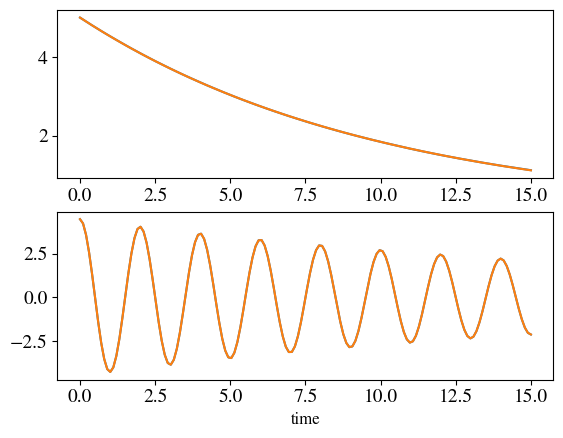

In [18]:
plot_expectation_values([result, result_ref])

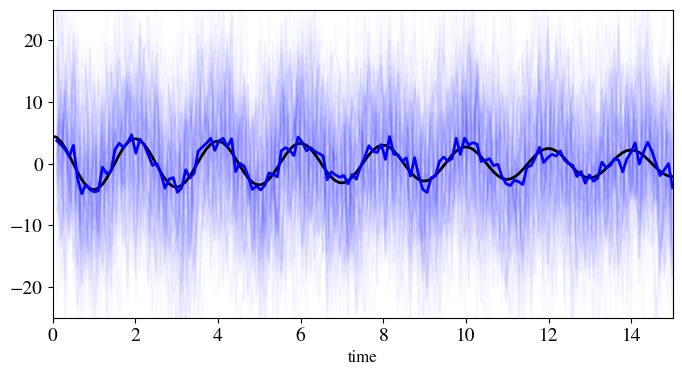

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))

M = np.sqrt(eta * gamma)

for m in result.measurement:
    ax.plot(times[1:], m[0, :].real / M, "b", alpha=0.025)

ax.plot(times, result_ref.expect[1], "k", lw=2)

ax.set_ylim(-25, 25)
ax.set_xlim(0, times.max())
ax.set_xlabel("time", fontsize=12)
ax.plot(
    times[1:], np.mean(result.measurement, axis=0)[0, :].real / M, "b", lw=2
)

## Versions

In [20]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0.dev0+4033695
Numpy Version:      2.2.4
Scipy Version:      1.15.2
Cython Version:     3.0.12
Matplotlib Version: 3.10.1
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------



qutip-jax: 0.1.1.dev5
qutip-qtrl: 0.2.0.dev0+acb71a0
qutip-qip: 0.5.0.dev0+d58a82d

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
